In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import json
import xml.etree.ElementTree as ET
import shutil

In [2]:
def xml_to_json(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    json_data = {
        "folder": root.find("folder").text,
        "filename": root.find("filename").text,
        "path": root.find("path").text,
        "source": {
            "database": root.find("source/database").text
        },
        "size": {
            "width": int(root.find("size/width").text),
            "height": int(root.find("size/height").text),
            "depth": int(root.find("size/depth").text)
        },
        "segmented": int(root.find("segmented").text),
        "objects": []
    }
    
    for obj in root.findall("object"):
        json_data["objects"].append({
            "name": obj.find("name").text,
            "pose": obj.find("pose").text,
            "truncated": int(obj.find("truncated").text),
            "difficult": int(obj.find("difficult").text),
            "bndbox": {
                "xmin": int(obj.find("bndbox/xmin").text),
                "ymin": int(obj.find("bndbox/ymin").text),
                "xmax": int(obj.find("bndbox/xmax").text),
                "ymax": int(obj.find("bndbox/ymax").text)
            }
        })
    
    return json_data

def convert_annotations(annotations_folder, output_folder, output_images_folder):
    # Create the output folders if they don't exist
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(output_images_folder, exist_ok=True)
    
    for xml_file in os.listdir(annotations_folder):
        if xml_file.endswith(".xml"):
            xml_path = os.path.join(annotations_folder, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            # Check if the XML file has only one bounding box
            if len(root.findall("object")) == 1:
                json_data = xml_to_json(xml_path)
                
                json_file = xml_file.replace(".xml", ".json")
                json_path = os.path.join(output_folder, json_file)
                
                with open(json_path, "w") as f:
                    json.dump(json_data, f, indent=4)
                
                print(f"Converted {xml_file} to {json_file}")
                
                # Get the image path from the JSON data and add the prefix
                image_path = os.path.join("wider_face/data", json_data["path"])
                image_file = os.path.basename(image_path)
                output_image_path = os.path.join(output_images_folder, image_file)
                
                # Copy the image file to the output folder
                shutil.copy2(image_path, output_image_path)
                print(f"Copied {image_file} to {output_images_folder}")

# Usage example
annotations_folder = "wider_face/data/WIDER_train_annotations/"
output_folder = "data_image/annotation/"
output_images_folder = "data_image/image/"
# convert_annotations(annotations_folder, output_folder, output_images_folder)

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data_image', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data_image','annotation', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data_image',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

In [18]:
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


In [19]:
train_images = tf.data.Dataset.list_files('data_image/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x / 255)


In [20]:
train_images

<_MapDataset element_spec=TensorSpec(shape=(120, 120, 3), dtype=tf.float32, name=None)>

In [21]:
test_images = tf.data.Dataset.list_files('data_image/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images = test_images.map(lambda x: x/255)

In [22]:
test_images

<_MapDataset element_spec=TensorSpec(shape=(120, 120, 3), dtype=tf.float32, name=None)>

In [23]:
val_images = tf.data.Dataset.list_files('data_image/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images = val_images.map(lambda x: x/255)

In [24]:
val_images

<_MapDataset element_spec=TensorSpec(shape=(120, 120, 3), dtype=tf.float32, name=None)>

In [37]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    return [label['objects'][0]['name']], [label['objects'][0]['bndbox']['xmin'],
                                           label['objects'][0]['bndbox']['ymin'],
                                           label['objects'][0]['bndbox']['xmax'],
                                           label['objects'][0]['bndbox']['ymax']]

def load_labels_wrapper(label_path):
    output = tf.py_function(load_labels, [label_path], [tf.string, tf.float32])
    # Directly set the shapes of the tensors without unpacking
    output[0].set_shape([1])  # Setting the shape for class label tensor
    output[1].set_shape([4])  # Assuming bbox contains 4 elements [xmin, ymin, xmax, ymax]
    return output


In [38]:
train_labels = tf.data.Dataset.list_files('data_image/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(load_labels_wrapper)

train_labels


<_MapDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.string, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [39]:
test_labels = tf.data.Dataset.list_files('data_image/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(load_labels_wrapper)

test_labels


<_MapDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.string, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [40]:
val_labels = tf.data.Dataset.list_files('data_image/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(load_labels_wrapper)

val_labels


<_MapDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.string, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [41]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3433, 3433, 524, 524, 678, 678)

In [42]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [43]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.string, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [44]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [45]:
test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.string, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [46]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [47]:
val

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.string, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [48]:
train.as_numpy_iterator().next()[1]

(array([[b'face'],
        [b'face'],
        [b'face'],
        [b'face'],
        [b'face'],
        [b'face'],
        [b'face'],
        [b'face']], dtype=object),
 array([[ 850.,   77.,  895.,  140.],
        [ 423., 1105.,  513., 1219.],
        [ 281.,   39.,  306.,   68.],
        [ 263.,  153.,  449.,  393.],
        [ 508.,  370.,  596.,  448.],
        [ 327.,  294.,  351.,  326.],
        [ 283.,  241.,  631.,  671.],
        [ 954.,  135.,  981.,  172.]], dtype=float32))

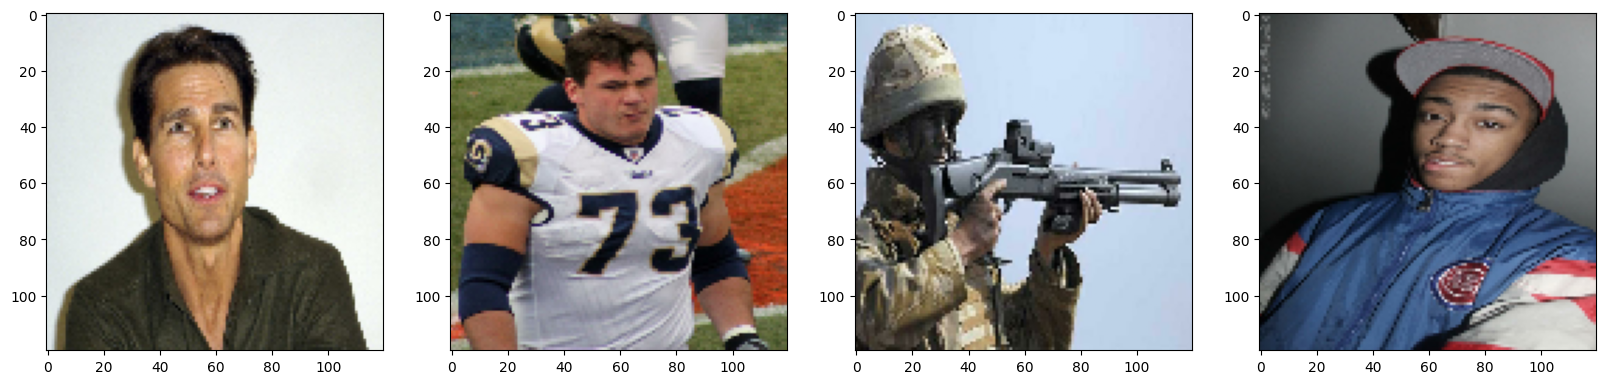

In [50]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    # Create a copy of the sample_image
    sample_image_copy = np.copy(sample_image)
    
    cv2.rectangle(sample_image_copy, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image_copy)

In [ ]:
import cv2
import albumentations as A
import matplotlib.pyplot as plt

# Extract the bounding box coordinates
x_min = label['objects'][0]['bndbox']['xmin']
y_min = label['objects'][0]['bndbox']['ymin']
x_max = label['objects'][0]['bndbox']['xmax']
y_max = label['objects'][0]['bndbox']['ymax']

# Get the image dimensions
height, width = img.shape[:2]

# Normalize the bounding box coordinates to the range [0.0, 1.0]
bbox = [x_min / width, y_min / height, x_max / width, y_max / height]

transform = A.Compose([
    A.RandomCrop(width=500, height=500),
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2), 
    A.RGBShift(p=0.2), 
    A.VerticalFlip(p=0.5)
], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels']))

transformed = transform(image=img, bboxes=[bbox], class_labels=['face'])

cropped_img = transformed['image']
cropped_labels = transformed['bboxes']

# Convert the cropped image from BGR to RGB color space
cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

# Extract the cropped bounding box coordinates
if cropped_labels:
    x_min, y_min, x_max, y_max = cropped_labels[0]

    # Convert the normalized coordinates back to pixel values
    x_min = int(x_min * 500)
    y_min = int(y_min * 500)
    x_max = int(x_max * 500)
    y_max = int(y_max * 500)

    # Draw the cropped bounding box on the cropped image
    cv2.rectangle(cropped_img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Display the cropped image with the bounding box using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cropped_img_rgb)
plt.axis('off')
plt.title('Cropped Image with Bounding Box')
plt.tight_layout()
plt.show()


In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data_image', 'image')):
        img = cv2.imread(os.path.join('data_image', 'image', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data_image', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            # Extract the bounding box coordinates
            x_min, y_min = label['shapes'][0]['points'][0]
            x_max, y_max = label['shapes'][0]['points'][1]

            # Get the image dimensions
            height, width = img.shape[:2]

            # Normalize the bounding box coordinates to the range [0.0, 1.0]
            bbox = [x_min / width, y_min / height, x_max / width, y_max / height]

        try: 
            for x in range(5):
                augmented = transform(image=img, bboxes=[bbox], class_labels=['face'])
                cv2.imwrite(os.path.join('data_image', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('data_image', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)